In [1]:
import sys, os
import pandas as pd
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn",
)

from sklearn import metrics
from scipy import stats
from flaml import AutoML # https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/

import torch
torch.manual_seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## Loading data

### Loading meta-analysis

In [2]:
meta_Df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_2.csv").drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq",
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})
meta_Df = meta_Df.sample(frac=1, random_state=0).reset_index(drop=True)
meta_Df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id,binder_id,seq_len_binder,seq_len_target,pdb_len_binder,pdb_len_target
0,A,"[""B""]",True,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,62,101,62,101
1,A,"[""B""]",False,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,58,621,58,621
2,A,"[""B""]",False,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,65,101,65,101
3,A,"[""B""]",False,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,64,101,64,101
4,A,"[""B""]",False,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,65,165,65,165
...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,63,195,63,195
3528,A,"[""B""]",False,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,65,101,65,101
3529,A,"[""B""]",False,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,63,193,63,193
3530,A,"[""B""]",False,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,65,101,65,101


In [3]:
meta_binders_encodings_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_binders"
meta_binders_files = sorted(os.listdir(meta_binders_encodings_path))  # keep files & embeddings aligned
meta_binders = [file.split(".")[0] for file in meta_binders_files]
meta_binders_embedings = [np.load(os.path.join(meta_binders_encodings_path, f))[0] for f in meta_binders_files]

meta_targets_embedings_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_targets"
meta_targets_files = sorted(os.listdir(meta_targets_embedings_path))  # keep files & embeddings aligned
meta_targets = [file.split(".")[0] for file in meta_targets_files]
meta_targets_embedings = [np.load(os.path.join(meta_targets_embedings_path, f))[0] for f in meta_targets_files]

In [4]:
# binder_id : target_id
meta_binder_target_Dict = dict(zip(meta_Df.binder_id, meta_Df.target_id))

# binder_id : label
meta_binder_lbl = dict(zip(meta_Df.binder_id, meta_Df.binder))

# assigning index/number to target (for later)
meta_target_idx = {target: idx for idx, target in enumerate(meta_targets)}

# all binders (list) but id is target id
meta_targets_per_binder = [meta_binder_target_Dict[b] for b in meta_binders]

# all binders (list) but id is target number
meta_groups_all = np.array([meta_target_idx[t] for t in meta_targets_per_binder])

# existing features/labels aligned to meta_binders
meta_binders_emb = [b.mean(axis=0) for b in meta_binders_embedings]
meta_targets_emb = [meta_targets_embedings[meta_target_idx[t]].mean(axis=0) for t in meta_targets_per_binder]
meta_labels = [meta_binder_lbl[b] for b in meta_binders]

In [5]:
smth1 = meta_binders_emb[1]
smth2 = meta_targets_emb[1]
np.concatenate([smth1, smth2], axis=0).shape

def build_Xy(binders, targets, labels_):
    # np.concatenate([binders[i], targets[i]], axis=0).shape --> (2304,)
    X = np.stack([np.concatenate([binders[i], targets[i]], axis=0) for i in range(len(binders))], axis=0)
    y = np.array(labels_)
    return X, y

X_train, y_train = build_Xy(meta_binders_emb, meta_targets_emb, meta_labels)

In [12]:
target_groups_Dict = {}
for i, target in enumerate(meta_Df.target_id.unique()):
    target_groups_Dict[target] = i
target_groups_Dict
groups_train = np.array([target_groups_Dict[row.target_id] for row in meta_Df.itertuples()])
groups_train

array([0, 1, 0, ..., 3, 0, 0])

### Loading bindcraft (test-set)

In [8]:
bindcraft_Df = pd.read_csv("./bindcraft_scores.csv")
bindcraft_Df = bindcraft_Df.sample(frac=1, random_state=0).reset_index(drop=True)
bindcraft_Df

encodings_path = "/work3/s232958/data/bindcraft/embeddings_esmC"

bindcraft_binders_files = [f"{row.binder_id}.npy" for row in bindcraft_Df.itertuples()]
bindcraft_binders = [file.split(".")[0] for file in bindcraft_binders_files]
bindcraft_binders_embedings = [np.load(os.path.join(encodings_path, f))[0] for f in bindcraft_binders_files]

bindcraft_targets_files = [f"{row.target_id}.npy" for row in bindcraft_Df.itertuples()]
bindcraft_targets = [file.split(".")[0] for file in bindcraft_targets_files]
bindcraft_targets_embedings = [np.load(os.path.join(encodings_path, f))[0] for f in bindcraft_targets_files]

In [14]:
# binder_id : target_id
bindcraft_binder_target_Dict = dict(zip(bindcraft_Df.binder_id, bindcraft_Df.target_id))

# binder_id : label
bindcraft_binder_lbl = dict(zip(bindcraft_Df.binder_id, bindcraft_Df.binder))

# assigning index/number to target (for later)
bindcraft_target_idx = {target: idx for idx, target in enumerate(bindcraft_targets)}

# all binders (list) but id is target id
bindcraft_targets_per_binder = [bindcraft_binder_target_Dict[b] for b in bindcraft_binders]

# all binders (list) but id is target number
bindcraft_groups_all = np.array([bindcraft_target_idx[t] for t in bindcraft_targets_per_binder])

# existing features/labels aligned to bindcraft_binders
bindcraft_binders_emb = [b.mean(axis=0) for b in bindcraft_binders_embedings]
bindcraft_targets_emb = [bindcraft_targets_embedings[bindcraft_target_idx[t]].mean(axis=0) for t in bindcraft_targets_per_binder]
bindcraft_labels = [bindcraft_binder_lbl[b] for b in bindcraft_binders]

X_test, y_test = build_Xy(bindcraft_binders_emb, bindcraft_targets_emb, bindcraft_labels)

## Train FLAML

In [21]:
import time
import numpy as np
from flaml import AutoML
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

BestModels = {}

# Testing different time budgets to see the "elbow point" of performance
for budget in [600, 900, 1200, 1500]:
    print(f"\n--- Starting AutoML with budget: {budget} seconds ---")
    
    start_time = time.time()
    automl = AutoML()
    
    settings = {
        "time_budget": budget,
        "task": "classification",
        "metric": "ap",
        "verbose": 0, # Reduced verbosity to keep the loop output clean
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
    }
    
    # Run FLAML
    automl.fit(X_train=X_train, y_train=y_train, groups=groups_train, **settings)
    
    # Prediction Logic
    y_pred = automl.predict(X_test)
    y_proba = automl.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    ap = average_precision_score(y_test, y_proba)
    auroc = roc_auc_score(y_test, y_proba)
    duration_sec = time.time() - start_time
        
    # Store results using budget as the key
    BestModels[budget] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "internal_cv_ap": 1 - automl.best_loss, # Convert loss back to AP
        "test_accuracy": acc,
        "test_ap": ap,
        "test_auroc": auroc,
        "actual_duration_sec": duration_sec 
    }
    
    print(f"Budget {budget}s finished. Test AP: {ap:.4f} | Test AUROC: {auroc:.4f}")


--- Starting AutoML with budget: 600 seconds ---
Budget 600s finished. Test AP: 0.4859 | Test AUROC: 0.5370

--- Starting AutoML with budget: 900 seconds ---
Budget 900s finished. Test AP: 0.4859 | Test AUROC: 0.5370

--- Starting AutoML with budget: 1200 seconds ---
Budget 1200s finished. Test AP: 0.4859 | Test AUROC: 0.5370

--- Starting AutoML with budget: 1500 seconds ---
Budget 1500s finished. Test AP: 0.4859 | Test AUROC: 0.5370


In [22]:
BestModels

{600: {'estimator': 'extra_tree',
  'best_config': {'n_estimators': 1062,
   'max_features': 0.022459281565629735,
   'max_leaves': 994,
   'criterion': 'entropy'},
  'internal_cv_ap': 0.423716730045695,
  'test_accuracy': 0.58,
  'test_ap': 0.4858593001576914,
  'test_auroc': 0.5370370370370371,
  'actual_duration_sec': 657.8673312664032},
 900: {'estimator': 'extra_tree',
  'best_config': {'n_estimators': 1062,
   'max_features': 0.022459281565629735,
   'max_leaves': 994,
   'criterion': 'entropy'},
  'internal_cv_ap': 0.423716730045695,
  'test_accuracy': 0.58,
  'test_ap': 0.4858593001576914,
  'test_auroc': 0.5370370370370371,
  'actual_duration_sec': 907.1740851402283},
 1200: {'estimator': 'extra_tree',
  'best_config': {'n_estimators': 1062,
   'max_features': 0.022459281565629735,
   'max_leaves': 994,
   'criterion': 'entropy'},
  'internal_cv_ap': 0.423716730045695,
  'test_accuracy': 0.58,
  'test_ap': 0.4858593001576914,
  'test_auroc': 0.5370370370370371,
  'actual_durat

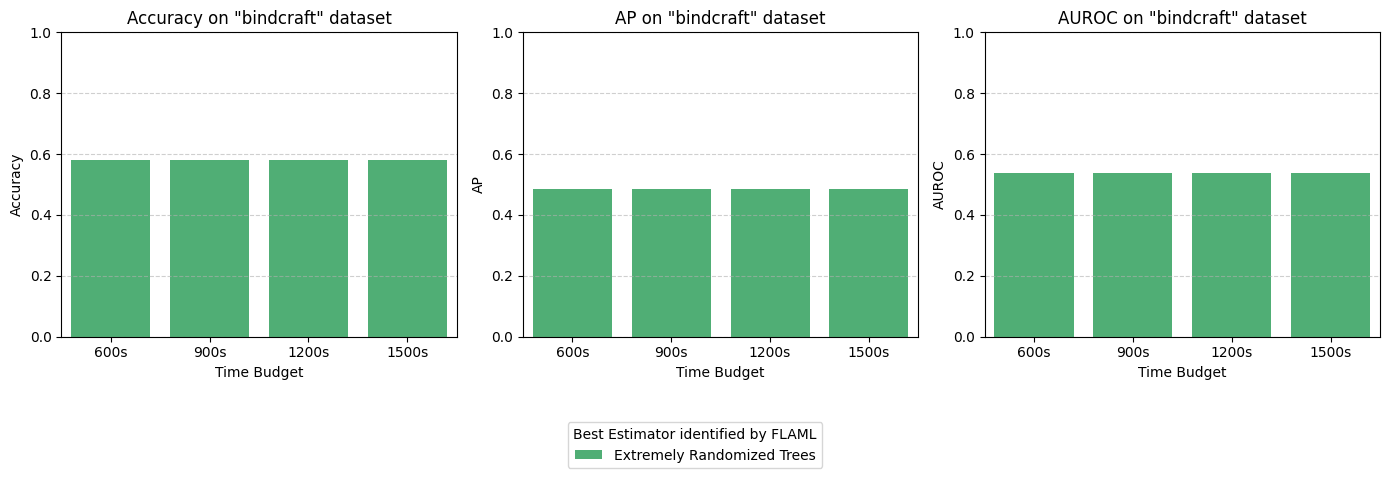

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Parse your results dictionary into a DataFrame
results = {
    600: {'estimator': 'extra_tree', 'test_accuracy': 0.58, 'test_ap': 0.4859, 'test_auroc': 0.5370},
    900: {'estimator': 'extra_tree', 'test_accuracy': 0.58, 'test_ap': 0.4859, 'test_auroc': 0.5370},
    1200: {'estimator': 'extra_tree', 'test_accuracy': 0.58, 'test_ap': 0.4859, 'test_auroc': 0.5370},
    1500: {'estimator': 'extra_tree', 'test_accuracy': 0.58, 'test_ap': 0.4859, 'test_auroc': 0.5370}
}

data_list = []
for budget, metrics in results.items():
    data_list.append({
        'Time Budget': f"{budget}s",
        'Estimator': "Extremely Randomized Trees", # Mapping 'extra_tree' to your preferred label
        'Accuracy': metrics['test_accuracy'],
        'AP': metrics['test_ap'],
        'AUROC': metrics['test_auroc']
    })

df_plot = pd.DataFrame(data_list)

# 2. Setup for subplots
metrics = ['Accuracy', 'AP', 'AUROC']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
palette = sns.color_palette("viridis", 25)

# Mapping colors to estimators
color_map = {
    "SGD Classifier": palette[3],
    "Extremely Randomized Trees": palette[17],
    "XGBoost": palette[24]
}

# 3. Generate the plots
for i, metric in enumerate(metrics):
    sns.barplot(
        data=df_plot, 
        x='Time Budget', 
        y=metric, 
        hue='Estimator', 
        palette=color_map, 
        ax=axes[i], 
        dodge=False
    )
    axes[i].set_title(f'{metric} on "bindcraft" dataset')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    
    # Remove individual legends to avoid clutter
    if axes[i].get_legend():
        axes[i].get_legend().remove()

# 4. Global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title='Best Estimator identified by FLAML', 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.2), 
    ncol=3
)

plt.tight_layout()
plt.savefig('flaml_performance_plateau.png', bbox_inches='tight')
plt.show()